<a href="https://colab.research.google.com/github/lauramenicacci/dl_tutorial_timeseries/blob/main/Tutorial_powerconsumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting power consumption in cities
## GRAD-E1394 Deep Learning -- Assignment 3
Author(s):
*   Katalin Bayer, K.Bayer@students.hertie-school.org
*   Laura Menicacci, L.Menicacci@students.hertie-school.org
*   Maren Rieker, M.Rieker@students.hertie-school.org


# Table of Contents


*   [Memo](#memo)
*   [Overview](#overview)
*   [Background & Prerequisites](#background-and-prereqs)
*   [Software Requirements](#software-requirements)
*   [Data Description](#data-description)
*   [Methodology](#methodology)
*   [Results & Discussion](#results-and-discussion)
*   [References](#references)

# Software requirements

This notebook requires Python >= 3.7. The following libraries are required:
*   pandas
*   numpy
*   matplotlib
*   sklearn
*   keras

In [ ]:
# !pip install pandas numpy matplotlib gluonts mxnet keras sklearn ipython datetime

In [ ]:
# Data manipulation 
import math
import pandas as pd
import numpy as np

# Data visualization 
import matplotlib.pyplot as plt
# import chart-studio

#Stationarity test 
from statsmodels.tsa.stattools import adfuller

#Auto-Correlation tests 
from statsmodels.graphics.tsaplots import plot_acf      # -> (ACF Plot)
from statsmodels.stats.stattools import durbin_watson   # -> (Durbin Watson Test Statistic)

# sklearn useful libraries
import sklearn

# LSTM and GRU implementation 
from keras.layers import LSTM, GRU

# DeepAR
from gluonts.model.deepar import DeepAREstimator 
from gluonts.mx import trainer
from gluonts.mx.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

#for Videos
from IPython.display import YouTubeVideo
from datetime import timedelta


# Description and basic formatting of data

## Data Download

Our dataset is easily downloadable from https://archive.ics.uci.edu/ml/datasets/Power+consumption+of+Tetouan+city 

In [ ]:
# Load Data into a pandas DataFrame and print column names to get an overview of the data
data = pd.read_csv("Tetuan City power consumption.csv")
print(data.columns)

Index(['DateTime', 'Temperature', 'Humidity', 'Wind Speed',
       'general diffuse flows', 'diffuse flows', 'Zone 1 Power Consumption',
       'Zone 2  Power Consumption', 'Zone 3  Power Consumption'],
      dtype='object')


In [ ]:
# Statistical information about the dataset
print(data.describe(include=[np.number], percentiles=[.5]) \
      .transpose().drop("count", axis=1), "\n")

# Check for any missing observations in the data set. This code will print the number of
# missing values for all columns in the given DataFrame
for column in data.columns:
  print('The variable: ', column, ' is missing ', data[column].isnull().sum(), ' observations.')

                                   mean          std           min  \
Temperature                   18.810024     5.815476      3.247000   
Humidity                      68.259518    15.551177     11.340000   
Wind Speed                     1.959489     2.348862      0.050000   
general diffuse flows        182.696614   264.400960      0.004000   
diffuse flows                 75.028022   124.210949      0.011000   
Zone 1 Power Consumption   32344.970564  7130.562564  13895.696200   
Zone 2  Power Consumption  21042.509082  5201.465892   8560.081466   
Zone 3  Power Consumption  17835.406218  6622.165099   5935.174070   

                                    50%          max  
Temperature                   18.780000     40.01000  
Humidity                      69.860000     94.80000  
Wind Speed                     0.086000      6.48300  
general diffuse flows          5.035500   1163.00000  
diffuse flows                  4.456000    936.00000  
Zone 1 Power Consumption   32265.920340

We now have a better idea of the type of data we are working with; however, for the prupose of this tutorial we are exclusively focusing on **Univariate Time Series Forecasting**. 

> *Univariate time series models* only consider the variable of interest and any past values of that same variable; alternatively, *multivariate time series models* use other time series data as dependent variables which adds to the model complexity and is useful when trying to forecast time series variables that are dependent on additional external factors that have also been recorded over time.​ For example trying to forecast a countries GDP.


## Data exploration

For the data exploration we select the variables of interests to us and drop the remaining information as they will not be featured in our models.

In [ ]:
# select a small subsample of the data to get a better idea 
data_small = data[['DateTime', 'Zone 1 Power Consumption',
       'Zone 2  Power Consumption', 'Zone 3  Power Consumption']] # remove first column of datetime
data_small = data_small.iloc[:1500] # take first 1500 rows
data_small

# set Date Time as Index
data_small['DateTime'] = pd.to_datetime(data_small['DateTime'], infer_datetime_format = True)
data_small = data_small.set_index(['DateTime']) 

,DateTime,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
0,1/1/2017 0:00,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,27335.69620,17872.34043,18442.40964
...,...,...,...,...
1495,1/11/2017 9:10,25822.78481,15446.80851,11959.51807
1496,1/11/2017 9:20,26539.74684,16158.05471,12439.51807
1497,1/11/2017 9:30,27171.64557,16526.44377,12838.55422
1498,1/11/2017 9:40,27785.31646,16891.18541,13353.25301


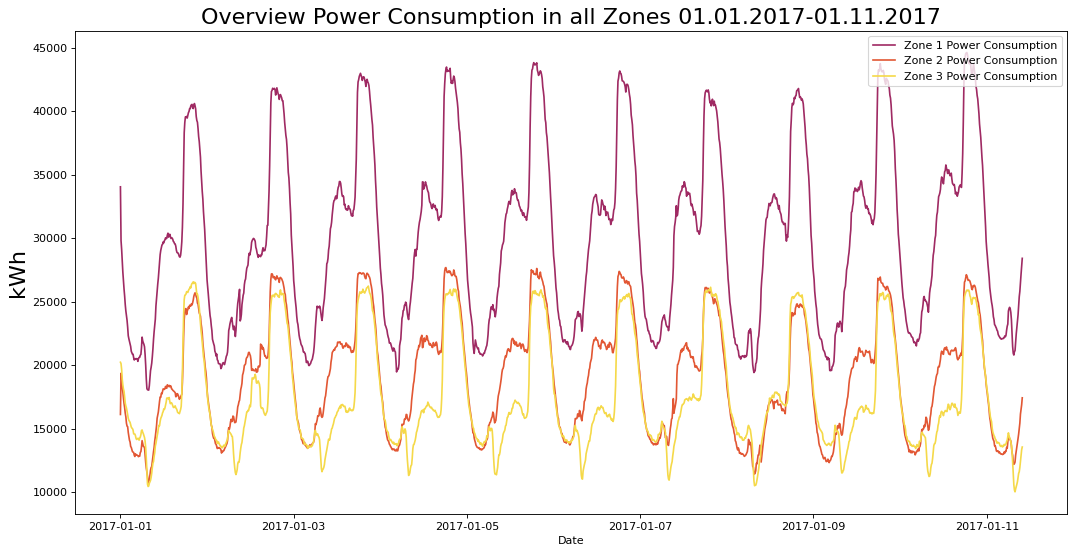

In [ ]:
# Plot one of the target variables for the shortened dataset
x=data_small.index

Zone1 = data_small['Zone 1 Power Consumption']
Zone2 = data_small['Zone 2  Power Consumption']
Zone3 = data_small['Zone 3  Power Consumption']
plt.figure(figsize=(16,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca() 


line1, = plt.plot(x, Zone1,color = '#9f2a63',label='Zone 1 Power Consumption')
line2, = plt.plot(x, Zone2, color = '#e25734', label = 'Zone 2 Power Consumption')
line3, = plt.plot(x, Zone3, color = '#f5d949', label = 'Zone 3 Power Consumption')


plt.title('Overview Power Consumption in all Zones 01.01.2017-01.11.2017', fontsize=20)
plt.xlabel('Date')
plt.ylabel('kWh', fontsize=20)
plt.legend(loc=1, prop={'size': 10})
plt.show()

# Data preparation for a time series analysis






In [ ]:
#Formatting the columns
power = data.loc[:,['DateTime','Zone 1 Power Consumption', 'Zone 2  Power Consumption', 'Zone 3  Power Consumption']]#,'Zone 1 Power Consumption', 'Zone 2 Power Consumption', 'Zone 3 Power Consumption']]
power["DT"] = pd.to_datetime(power["DateTime"])
power.columns = power.columns.str.replace(' ', '')
#Aggregate consumption
power["MeanConsumption"] = power[['Zone1PowerConsumption', 'Zone2PowerConsumption', 'Zone3PowerConsumption']].mean(axis=1)

#Inserting dummy variables in order to aggregate 10 minute data at the hourly 
# level in the next step
power["Year"] = 2017
power["Month"]=pd.DatetimeIndex(power['DT']).month
power["Day"]=pd.DatetimeIndex(power['DT']).day 
power["Hour"]=pd.DatetimeIndex(power['DT']).hour



In [ ]:
#Creating a new dataframe with observations aggregated for every hour
power_hour = power.groupby(["Year", "Month", "Day", "Hour"], as_index=False).mean().copy()
power_hour["DT"] = pd.to_datetime(power_hour[["Year", "Month", "Day", "Hour"]])
power_hour = power_hour.drop(["Year", "Month", "Day", "Hour"], axis = 1) # remove superfluous dummies again

# Reset hourly Date Time index
power_hour = power_hour.set_index('DT')
print('The hourly aggregated DataFrame has dimensions:', power_hour.shape, '.')
power_hour


The hourly aggregated DataFrame has dimensions: (8736, 4) .


,Zone1PowerConsumption,Zone2PowerConsumption,Zone3PowerConsumption,MeanConsumption
DT,,,,
2017-01-01 00:00:00,29197.974683,18026.747720,19252.048193,22158.923532
2017-01-01 01:00:00,24657.215190,16078.419453,17042.891567,19259.508737
2017-01-01 02:00:00,22083.037973,14330.699088,15676.144578,17363.293880
2017-01-01 03:00:00,20811.139240,13219.452887,14883.855422,16304.815849
2017-01-01 04:00:00,20475.949367,12921.580547,14317.108433,15904.879449
...,...,...,...,...
2017-12-30 19:00:00,37513.814957,32497.698680,16926.770708,28979.428115
2017-12-30 20:00:00,37008.871988,32020.251610,16998.799520,28675.974373
2017-12-30 21:00:00,35358.174905,30757.901197,16608.883553,27574.986552


##Stationarity

###Visually Inspect Time Series for Stationarity 
In the **parametric inference** approach (which we are taking in this tutorial) , it is assumed that the underlying stationary stochastic process has a certain structure.

In the case of time series modeling, the expectation is that the data generating process can be described with only a few parameters - primarily **AR** and **MA lags**.

By contrast, in **non-parametric inference** approaches, the covariance of the process is estimated, without assuming any specifc underlying samppling from a distribution with a particular structure - hence, non-parametric.

> Parametric model estimation requires  stationarity assumption


**Stationarity is a stochastic process whose unconditional probability distribution does not change across time, for any two observations in the data.** The direct implication is that parameters such as mean and variance do not change over time. 

Visually, stationarity is satisfied when a line can be drawn through the middle of the time series and it is flat - seasonal cycles are allowed but there should not be any obvious updwards or downwards trends across time.


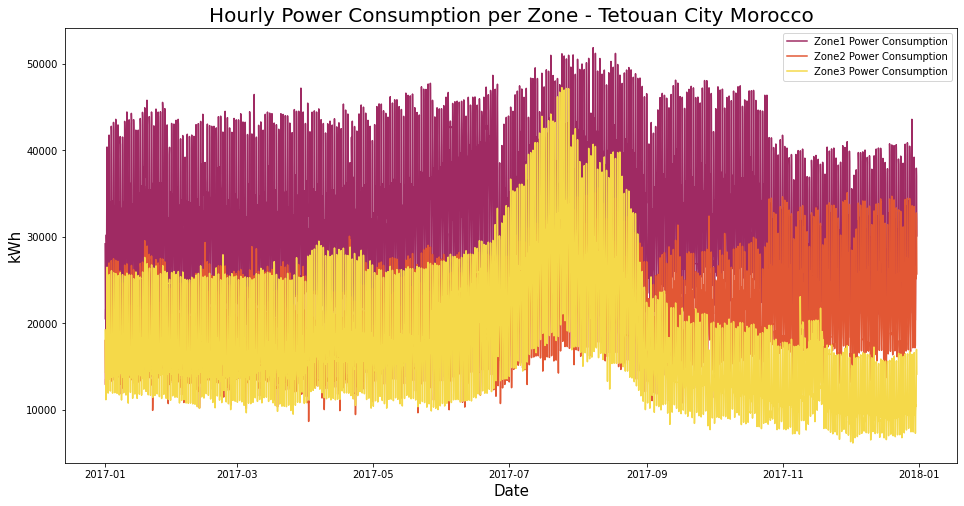

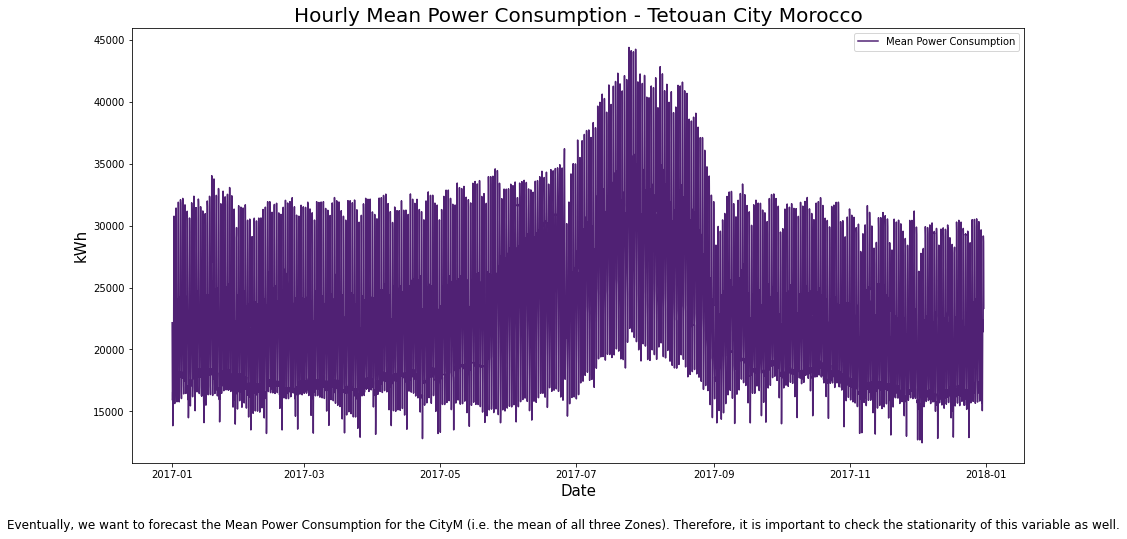

In [ ]:
# Plotting Power Consumption for each Zone in Tetouan City Seperately. 
x=power_hour.index
y1=power_hour["Zone1PowerConsumption"]
y2=power_hour["Zone2PowerConsumption"]
y3=power_hour["Zone3PowerConsumption"]

plt.figure(figsize=(16,8))
plt.plot(x, y1, label = "Zone1 Power Consumption", color="#9f2a63")
plt.plot(x, y2, label = "Zone2 Power Consumption", color="#e25734")
plt.plot(x, y3, label = "Zone3 Power Consumption",color ="#f5d949")

plt.title("Hourly Power Consumption per Zone - Tetouan City Morocco", size = 20)
plt.xlabel('Date', size = 15)
plt.ylabel('kWh', size = 15)
plt.legend(loc=1, prop={'size': 10})
plt.savefig('Hourly_PowerConsumption_perZone.png',bbox_inches='tight', dpi=150)
plt.show()

# Plotting the Hourly Mean Power Consumption for the entire City 
MeanConsumption =power_hour["MeanConsumption"]

plt.figure(figsize=(16,8))
plt.plot(x, MeanConsumption, label = "Mean Power Consumption", color="#3d0965", alpha = 0.9)

plt.title("Hourly Mean Power Consumption - Tetouan City Morocco", size = 20)
plt.xlabel('Date', size = 15)
plt.ylabel('kWh', size = 15)
plt.figtext(0.5, 0.01, 'Eventually, we want to forecast the Mean Power Consumption for the CityM (i.e. the mean of all three Zones). Therefore, it is important to check the stationarity of this variable as well.', wrap=True,  horizontalalignment='center', fontsize=12)
plt.legend(loc=1, prop={'size': 10})
plt.savefig('Hourly_MeanPowerConsumption.png',bbox_inches='tight', dpi=150)
plt.show()


Evidentally, our time series is not stationary are there are some strong trends present in the time frame between July and September 2017, which disrupt the otherwise fairly stationary data.

##Statistical Test for Stationarity

It is always useful to test whether stationarity is satisfied using a statistical test in addition to inspecting the data visually. Most commonly an **Augmented Dickey Fuller (ADF) Test** is carried out.  

- H0: a unit root is present in a time series sample -> the time series is **not** stationary.
- H1: we have stationarity or trend-stationarity.

The resulting test statistic is a negative number, the more negative the value is, the more confidently we reject the null hypothesis, that a unit root is present in our data. 


In [ ]:
#Calculates statistics for target variable
print(adfuller(power_hour["MeanConsumption"]))

(-2.573768830541299, 0.09854080867954679, 37, 8698, {'1%': -3.4311020385052733, '5%': -2.8618723508056814, '10%': -2.566946905374546}, 128372.67391899043)


###Interpreting the ADF Test results
(ADF Test statistic, p-value, number of lags in Regression to Determine the t-statistic, number of observations, {T values corresponding to the ADF Test})

Since in our case, the critical value falls between '5%': -2.861 < **-2.57** < '10%': -2.56, we could not reject the null hypothesis at  the 5% confidence interval. 

Hence, as expected on the basis of the visualisation, we now have the statistical confirmation that our time series is not stationary. **Therefore, before proceeding with any modeling, we must transform the data set into a stationary one.**

The standard approach is to simply take the differenced mean of the variable of interest, and to then re-test for stationarity. **By taking the differenced mean we can remove time specifc trends** in the data as we consider the difference between observations at time_t and time_t+1 as opposed to actual observed power consumption. 


### Turning the data set stationary
Calculating the 1 hour differentiated mean and adding it as 1-hour, 2-hours and 24-hour lags on the covariates dataset.

In [ ]:
def differencingTimeSeries(dataY):
  dataY['diff_mean_1'] = dataY['MeanConsumption'].diff(periods=1)
  dataY['diff_mean_Zone1'] = dataY['Zone1PowerConsumption'].diff(periods=1)
  dataY['diff_mean_Zone2'] = dataY['Zone2PowerConsumption'].diff(periods=1)
  dataY['diff_mean_Zone3'] = dataY['Zone3PowerConsumption'].diff(periods=1)
  

def LaggingTimeSeries(dataX, dataY):
  dataX['lagged_mean_1'] = dataY['diff_mean_1'].shift(1)
  dataX['lagged_mean_2'] = dataY['diff_mean_1'].shift(2)
  dataX['lagged_mean_24'] = dataY['diff_mean_1'].shift(24)
  dataX['lagged_mean_1_Zone1'] = dataY['diff_mean_Zone1'].shift(1)
  dataX['lagged_mean_2_Zone1'] = dataY['diff_mean_Zone1'].shift(2)
  dataX['lagged_mean_24_Zone1'] = dataY['diff_mean_Zone1'].shift(24)  
  dataX['lagged_mean_1_Zone2'] = dataY['diff_mean_Zone2'].shift(1)
  dataX['lagged_mean_2_Zone2'] = dataY['diff_mean_Zone2'].shift(2)
  dataX['lagged_mean_24_Zone2'] = dataY['diff_mean_Zone2'].shift(24)  
  dataX['lagged_mean_1_Zone3'] = dataY['diff_mean_Zone3'].shift(1)
  dataX['lagged_mean_2_Zone3'] = dataY['diff_mean_Zone3'].shift(2)
  dataX['lagged_mean_24_Zone3'] = dataY['diff_mean_Zone3'].shift(24)

In [ ]:
stationary_power = power_hour
stationary_power.info

#Using the differentiating and lagging function to calculate lags in the training set
differencingTimeSeries(stationary_power)
LaggingTimeSeries(stationary_power,stationary_power)


###Retesting the Differenced Mean Time Series for Stationarity 

The results below show that the trasnformation yielded a success. We now strongly reject the null of a unit root being present, and also visually it is clear that there are no obvious time series trends. 



(-21.61779516817581, 0.0, 37, 8697, {'1%': -3.431102125001841, '5%': -2.86187238902655, '10%': -2.566946925719781}, 140517.47824772936)


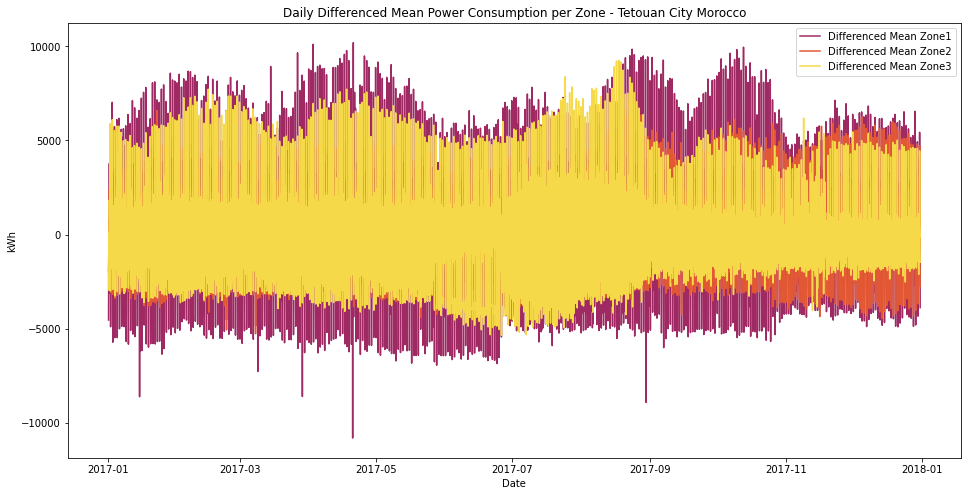

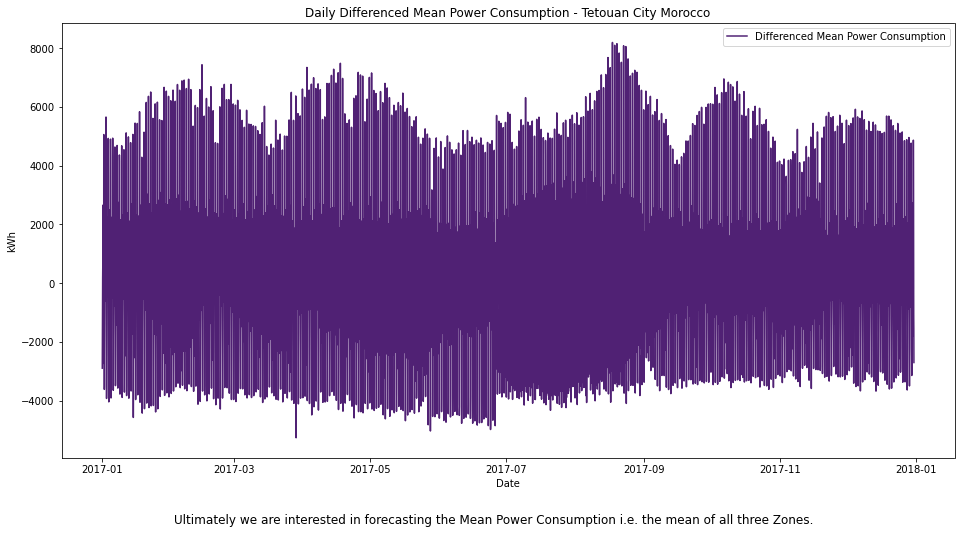

In [ ]:
#Calculates statistics for the differentiated mean to check if it is in fact stationary.
diff_mean=stationary_power["diff_mean_Zone1"].iloc[1:]
print(adfuller(diff_mean))

#Plotting energy consumption per datetime for each of the three zones. 
x=stationary_power.index
y1=stationary_power["diff_mean_Zone1"]
y2=stationary_power["diff_mean_Zone2"]
y3=stationary_power["diff_mean_Zone3"]

plt.figure(figsize=(16,8))
plt.plot(x, y1, label = "Differenced Mean Zone1", color="#9f2a63")
plt.plot(x, y2, label = "Differenced Mean Zone2", color="#e25734")
plt.plot(x, y3, label = "Differenced Mean Zone3",color ="#f5d949")

plt.xlabel('Date')
plt.ylabel('kWh')
plt.title("Daily Differenced Mean Power Consumption per Zone - Tetouan City Morocco")
plt.legend()
plt.savefig('Daily_PowerConsumption_perZone_Stationary.png',bbox_inches='tight', dpi=150)
plt.show()

z=stationary_power["diff_mean_1"]

plt.figure(figsize=(16,8))
plt.plot(x, z, label = "Differenced Mean Power Consumption", color="#3d0965", alpha = 0.9)

plt.xlabel('Date')
plt.ylabel('kWh')
plt.title("Daily Differenced Mean Power Consumption - Tetouan City Morocco")
plt.figtext(0.5, 0.01, 'Ultimately we are interested in forecasting the Mean Power Consumption i.e. the mean of all three Zones.', wrap=True,  horizontalalignment='center', fontsize=12)
plt.legend()
plt.savefig('Daily_MeanPowerConsumption_Stationary.png',bbox_inches='tight', dpi=150)
plt.show()


##Testing for Auto-Correlation

###Inspecting the Auto-Correlation Function (AFC) plot
####Key Assumption of AFC: 

- weak stationarity

If our data is stationary, that implies that the mean and variance of the time series is constant, this means that across time there is no correlation.
Therefore, we plot the Auto-Correlation Function for the original time series as opposed to the differenced mean series. 

####How to interpret Results:
In the plot below we notice that the peaks repeat at the 24 and 48 hour lags -> makes sense, we would expect power consumption of the day and two days prior to be highly correlated with today's power consumption.

<Figure size 1152x576 with 0 Axes>

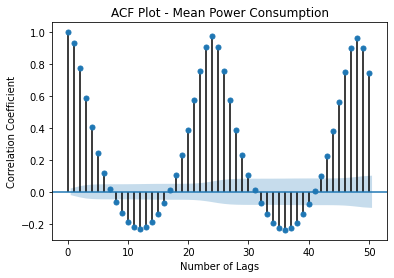

In [ ]:
plt.figure(figsize=(16,8))
plot_acf(power_hour.MeanConsumption, lags = 50, )
plt.xlabel('Number of Lags')
plt.ylabel('Correlation Coefficient')
plt.title("ACF Plot - Mean Power Consumption")
plt.savefig('ACFPlot_MeanPowerConsumption.png',bbox_inches='tight', dpi=150)
plt.show()


###Testing for Auto-Correlation with the Durbin-Watson Test
The second method to measure the autocorrelation of residuals in Python: is by performing the Durbin-Watson test. Note that this only test for a lag of first order (i.e. correlation w.r.t. observation_t-1, corresponding to an AR(1) model).

####The Hypotheses for the Durbin Watson test are:

H0 = no first order autocorrelation, and H1 = first order correlation exists.

####Key Assumptions are:

- Errors are normally distributed with a mean of 0
- Errors are stationary

Again, apply this test after the time series has been stationarized.

####How to interpret results:
The Durbin Watson test reports a test statistic, with a value from 0 to 4, where:

2 is no autocorrelation.
(0, 2) is positive autocorrelation (common in time series data).
(2, 4) is negative autocorrelation (less common in time series data).

As a rule of thumb, test statistic values that fall between (1.5, 2.5) are considered as relatively normal. Any values falling outside of this range suggests we should reject the null hypothesis.

####Our results:
A DW test statistic of approximately 0.007440 is a very strong indicator for positive autocorrelation and we reject the Null Hypothesis that no Auto-Correlation of first order is present.  

In [ ]:
#perform Durbin-Watson test
durbin_watson(power_hour.MeanConsumption)

0.007438971306829517

# Benchmark Time Series Model (ARIMA)

Statistical Time Series Models without any Deep Learning components. 

In [ ]:
def show_fit_report(dates, pred, test, title):
  # Plot outputs
  x = np.arange(min(len(pred), len(test)))
  plt.figure(figsize=(16,8))
  plt.plot(dates, test[x], color = "blue", label = "Actual values")
  plt.plot(dates, pred[x], color="red", label='Predicted values')

  plt.xlabel('Number of Forecasted Observations', size = 15)
  plt.ylabel('Energy consumption (kWh)', size = 15)
  plt.title(title, size = 20)
  plt.xticks()
  plt.yticks()
  plt.legend()
  plt.show()
  
def show_fit(pred, test):
    x = np.arange(min(len(pred), len(test)))
    plt.figure(figsize=(16,8))
    plt.scatter(x, test[x])
    plt.plot(x, pred[x])
    plt.show()
    
def roos_train(y_train, model, method, maxtrain):
    MAX_MODEL_CONDITION = 1e15
    n = min(maxtrain, len(y_train))
    try:
        print("Try estimating model")
        model.fit(y_train[-n:])
        model_condition = np.linalg.cond(model.arima_res_.cov_params())
        print("Model condition:", model_condition)
        if model_condition > MAX_MODEL_CONDITION:
            raise
    except:
        try:
            print("Try creating model")
            model = auto_arima(y_train[-n:], 
                             m=24, with_intercept=True,
                             trace=True, suppress_warnings=True,
                             method=method, error_action='ignore')
            model_condition = np.linalg.cond(model.arima_res_.cov_params())
            print("Model condition:", model_condition)
        except:
            print("WARNING: Model not created/estimated")
    return model

def roos_forecast(y_test, horizon, model):
    y_predict = []
    cut = 0
    n = len(y_test)
    while cut + horizon < n:
        y_predict = np.append(y_predict, model.predict(horizon))
        cut = cut + horizon
        print("forecast upto:", cut)
        model.update(y_test[cut-horizon:cut])
    # process remaining observations
    y_predict = np.append(y_predict, model.predict(n-cut))
    model.update(y_test[cut:n])
    assert len(y_predict) == n
    return y_predict
    
def roos_arima(y, n_est=8, horizon=24, method='powell', maxtrain=24*120):
    y_oos = np.full(len(y), np.NaN)
    tscv = TimeSeriesSplit(n_est)
    model = None
    for train_index, test_index in tscv.split(y):
        print("TRAIN:", train_index[0], train_index[-1], "TEST:", test_index[0], test_index[-1])
        model = roos_train(y.iloc[train_index], model, method, maxtrain)
        print(model.summary())
        y_predict = roos_forecast(y.iloc[test_index], horizon, model)
        y_oos[test_index] = y_predict
        show_fit(y_predict, y.iloc[test_index].values)
    print(model.summary())
    return y_oos


# When Run = True: Run the procedure, first for each zone, then for the total, or reload
# When Run = False: the saved results from the github repo are loaded into the code, 
# based on the results of a previous run of the entire model. Currently run = False to
# prevent excessive running time.
run = False
save_results = False
if run:    
    fc_Zone1 = roos_arima(power_hour.loc[:, ["Zone1"]])
    if save_results: fc_Zone1.tofile("Zone1.bnf")
    fc_Zone2 = roos_arima(power_hour.loc[:, ["Zone2"]])
    if save_results: fc_Zone2.tofile("Zone2.bnf")
    fc_Zone3 = roos_arima(power_hour.loc[:, ["Zone3"]])
    if save_results: fc_Zone3.tofile("Zone3.bnf")
    fc_Mean = roos_arima(power_hour.loc[:, ["MeanConsumption"]])
    if save_results: fc_Mean.tofile("Mean.bnf")
else:
    fc_Zone1 = np.fromfile("Zone1.bnf")
    fc_Zone2 = np.fromfile("Zone2.bnf")
    fc_Zone3 = np.fromfile("Zone3.bnf")
    fc_Mean = np.fromfile("Mean.bnf")

# Evaluate results    
n_NaN = len(fc_Mean[np.isnan(fc_Mean)])
y = power_hour.loc[:, ["MeanConsumption"]].values.reshape(-1)
fc_Comp = (fc_Zone1 + fc_Zone2 + fc_Zone3)/3
fc_Naive = np.array([np.NaN if i < n_NaN else y[i-24] for i in np.arange(len(y))])

from math import sqrt
def rmse(e, first=0): return sqrt(np.mean(np.square(e[first:])))
def mae(e, first=0): return np.mean(np.abs(e[first:]))
def mse(e,first=0): return np.mean(np.square(e[first:]))

print("RMSEs:")
print("Naive\t\t", rmse(y - fc_Naive, n_NaN))
print("Direct\t\t", rmse(y - fc_Mean, n_NaN))
print("Composite\t", rmse(y - fc_Comp, n_NaN))

print("MAEs:")
print("Naive\t\t", mae(y - fc_Naive, n_NaN))
print("Direct\t\t", mae(y - fc_Mean, n_NaN))
print("Composite\t", mae(y - fc_Comp, n_NaN))

print("MSEs:")
print("Naive\t\t", mse(y - fc_Naive, n_NaN))
print("Direct\t\t", mse(y - fc_Mean, n_NaN))
print("Composite\t", mse(y - fc_Comp, n_NaN))


RMSEs:
Naive		 1152.5012354728833
Direct		 966.150731463122
Composite	 975.379931186991
MAEs:
Naive		 760.18744189186
Direct		 669.5599602138535
Composite	 681.4591806187115
MSEs:
Naive		 1328259.0977665223
Direct		 933447.2359067259
Composite	 951366.0101623393


##Plotting Time Series Forecasts for Benchline Model

###Plotting Forecasts for Entire Horizon 

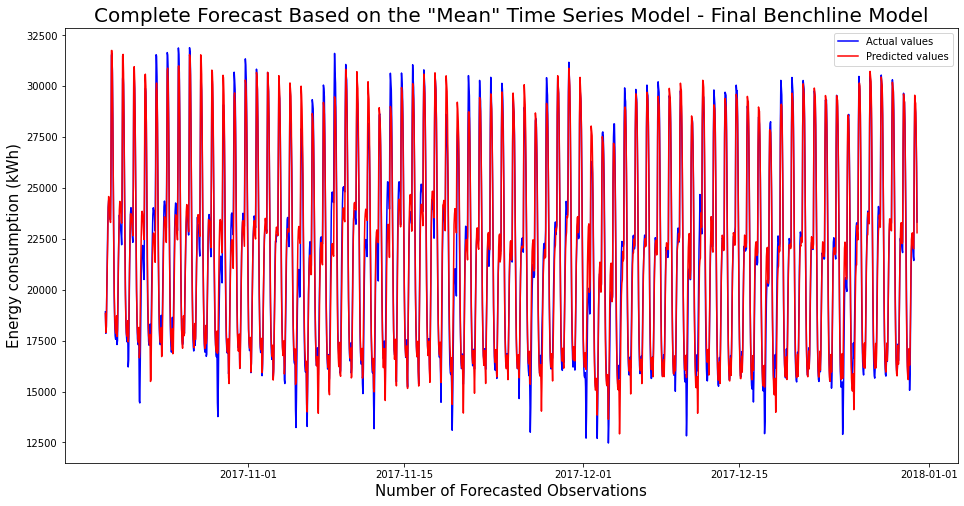

In [ ]:
n_oos = 1747
dates = np.array(power_hour.index[-n_oos:])
y1 = power_hour.loc[:, ["MeanConsumption"]].values.reshape(-1)

# Below the different type of Benchmark Models have been plotted. Since the "Mean" forecast performs best,
# this is the baseline model that is used to compare the forecasts of the Deep Learning Models against.

#show_fit_report(dates, fc_Naive[-n_oos:], y1[-n_oos:], 'Complete Forecast Based on the "Naive" Time Series Model')
#show_fit_report(dates, fc_Comp[-n_oos:], y1[-n_oos:], 'Complete Forecast Based on the "Composite" Time Series Model')
show_fit_report(dates, fc_Mean[-n_oos:], y1[-n_oos:], 'Complete Forecast Based on the "Mean" Time Series Model - Final Benchline Model')

###Plotting Forecasts for Last Week of Observations Only

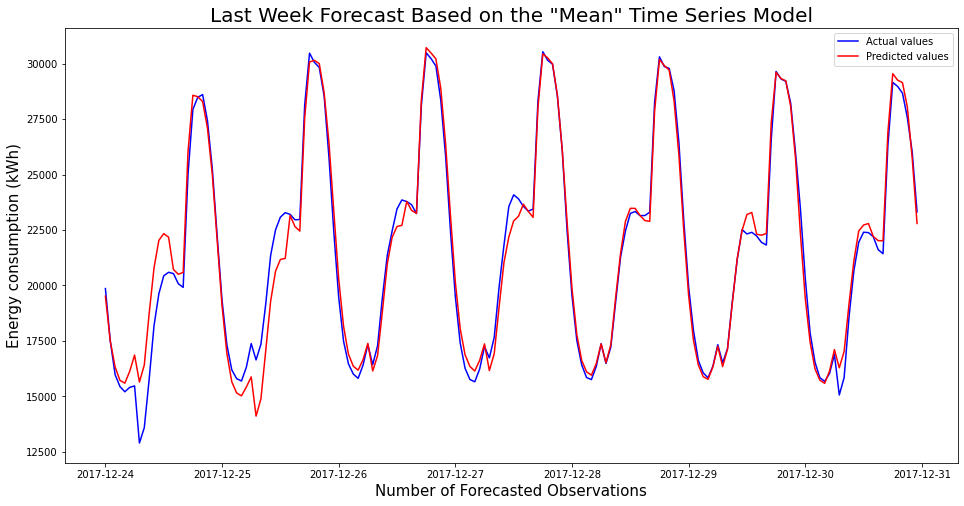

In [ ]:
n_oos = 1747
dates = power_hour.index[-7*24:]
y1 = power_hour.loc[:, ["MeanConsumption"]].values.reshape(-1)

#show_fit_report(dates, fc_Naive[-7*24:], y1[-7*24:], 'Last Week Forecast Based on the "Naive" Time Series Model')
#show_fit_report(dates, fc_Comp[-7*24:], y1[-7*24:], 'Last Week Forecast Based on the "Composite" Time Series Model')
show_fit_report(dates, fc_Mean[-7*24:], y1[-7*24:], 'Last Week Forecast Based on the "Mean" Time Series Model')

# Recurrent Neural Networks and Long-Short-Term-Memory Algorithm

LSTM model is a pretty famous architecture in the realm of Recurrent Neural Networks. It distinguished among other similar models thanks to its complex structure of multiple gates - inspired to the Residual NN logic - that allowed the model to 'remember' important information about previous data, as it is required for sequencial data as time series. 

We choose Mean-Squared-Error (MSE) as our primary cost function given that our dataset is of high quality, i.e., there are no outliers as a result of data errors that could otherwise result in model overfit using this error metric

Below you can find a picture of how an LSTM cell works, with its three gates: input, forget and output. You can also find useful visualizations of how the typical LSTM input data looks like.

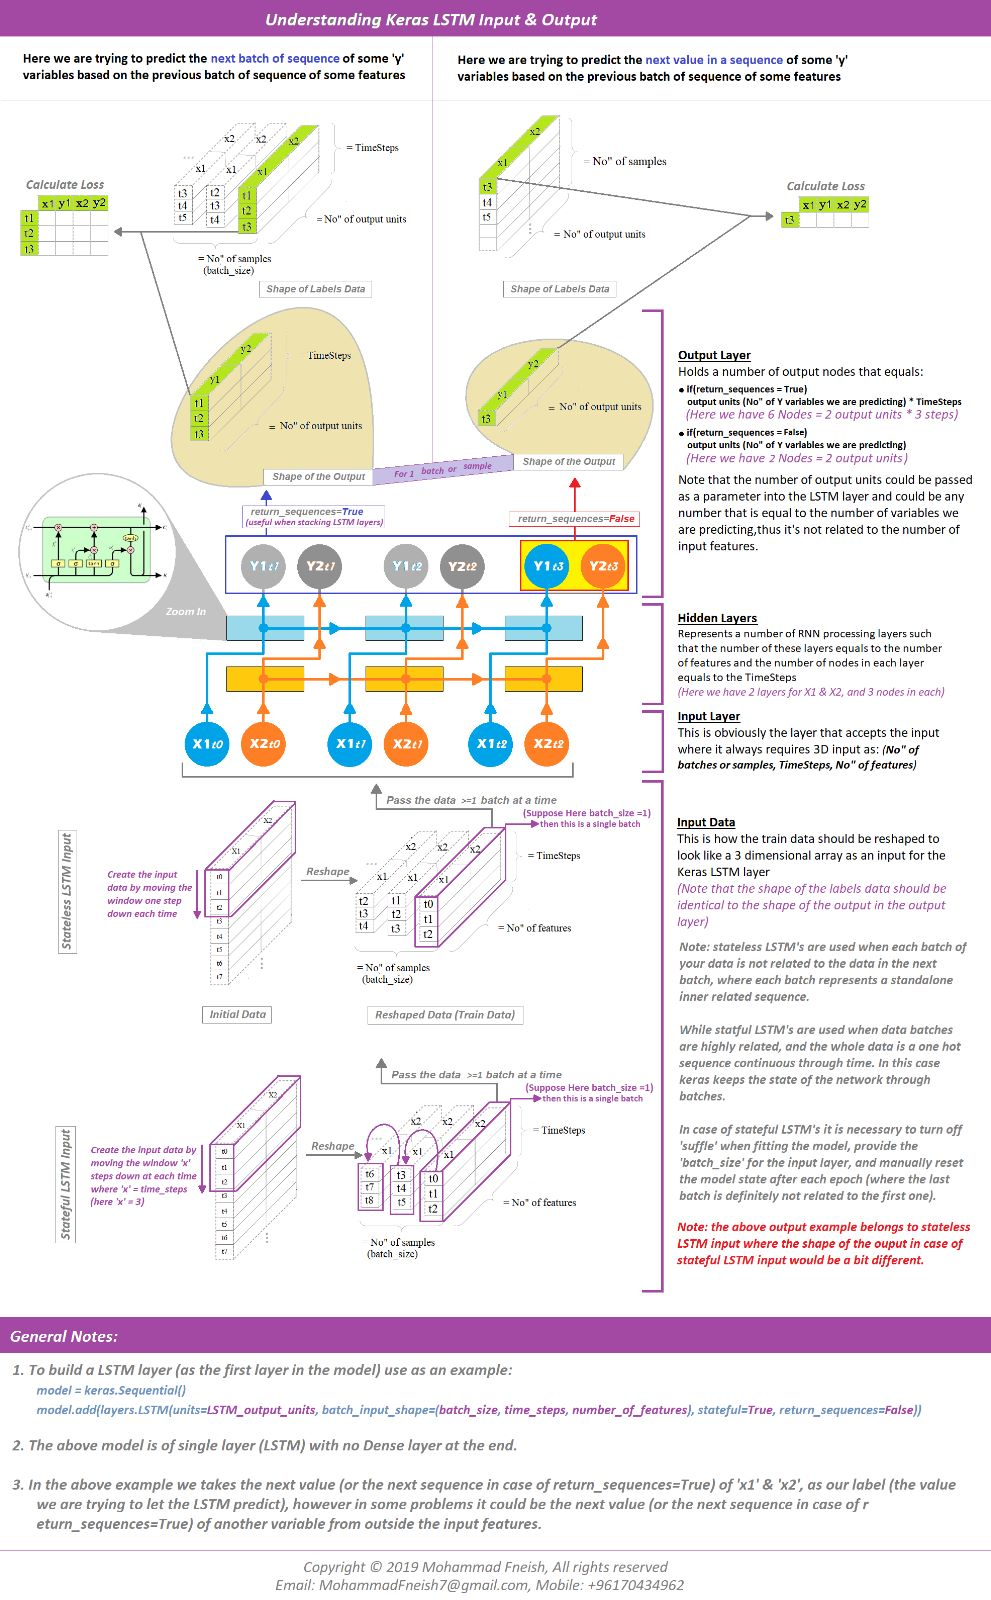

### Implementation of LSTM and GRU models

We perform a univariate time series forecastin on  the Mean Energy Consumption variable that we constructed previously. We will predict the last 20% of our whole time series. 

We use the [Keras](https://keras.io/) library, together with some [sklean](https://scikit-learn.org/stable/index.html) built-in functions.

The implementation of the model goes as follows:
* We split the data into train and test sets, keeping aside the las 20% of the time series
* We preprocess the data as required for the LSTM to train. Since LSTM is sensitive to input data, especially when using sigmoid or tanh function, we normalise - using sklearn function [MinMaxScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) - and reshape data into a 3D shape dimension of the format [samples, time steps, features] thanks to the keras built-in function [TimeSsriesGenerator()](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/TimeseriesGenerator). 
* We fit the our model using an LSTM layer of 720 units and 4 fully-connected layers. We chose the ADAM function as our optimizer and an hyperbolic tangent function as our activation function. Mean Squared Error is our loss function. 
* We train the model for 50 epochs, implementing an early stopping with patience = 3
* We predict values on the test set and rescale them to their original numbers to be able to evaluate performance
* We evaluate evaluate predictions with a classic sklearn MSE function
* We plot our results, with the first graph referring to the values for the Mean Consumption on the whole horizon and the second graph referring to the values for the last 10 days, for a better inspection of the model prediction. In the plots, we represent the predicted values with the red colour, and the observations with the blue colour.

Performance is quite good, almost half of our benchmark model.

In [ ]:
# import modules
from sklearn.preprocessing import MinMaxScaler    
from keras.preprocessing.sequence import TimeseriesGenerator  

# define parameters
n_input = 24 # look back 
batch_size = 48 # batch size

In [ ]:
# Support Functions

# Function that selects the variable of interest and the desired test ratio to calculate and output the training and test sets
scaler = MinMaxScaler(feature_range=(0, 1))
  
def split_train_test(data, test_ratio):

  test_size = int(len(data) * test_ratio)
  
  df_train = data.loc[:,["diff_mean_1"]].iloc[:-test_size,:].copy()
  df_test = data.loc[:,["diff_mean_1"]].iloc[-test_size:,:].copy()
 
  return df_train, df_test

def fit_lstm(train_data, EPOCHS):
  model = Sequential()
  model.add(LSTM(720, activation = "tanh", input_shape = (n_input, n_features))) # vanilla LSTM
  model.add(Dense(4))
  model.compile(optimizer = "adam", loss = "mse")
  model.fit(train_data, epochs= EPOCHS, batch_size = batch_size, shuffle = False, callbacks = [EarlyStopping(monitor="loss", min_delta=0.001, verbose=1, patience=3)])
  return model

def fit_GRU(train_data, EPOCHS):
  model = Sequential()
  model.add(GRU(720, activation = "tanh", input_shape = (n_input, n_features))) # GRU
  model.add(Dense(4))
  model.compile(optimizer = "adam", loss = "mse")
  model.fit(train_data, epochs= EPOCHS, batch_size = batch_size, shuffle = False, callbacks = [EarlyStopping(monitor="loss", min_delta=0.001, verbose=1, patience=3)])
  return model


def predict(model, test_data): # function that predicts the model and returns values scaled in the proper way for analysis 
   predicted_values = model.predict(test_data)

   return predicted_values

def plot_forecast(predictions, test_set, dates, title, filename):
    # Plot the actual versus prediction values
    x = dates # substitute w dates df?
    plt.figure(figsize=(16,8), dpi=150, facecolor='w', edgecolor='k')
    ax = plt.gca() 
    line1, = plt.plot(x, test_set, color = 'b', label='Actual')
    line2,=  plt.plot(x, predictions[:,1],'red',label='Predicted')
    
    plt.title(title, fontsize=20)
    plt.ylabel('kWh', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.legend(loc=2, prop={'size': 10})
    
    # save figure 
    plt.savefig(filename, bbox_inches = "tight", dpi =150)
    plt.show()

def plot_forecast_lastweek(predictions, test_set, dates, title, filename):
    # Plot the actual versus prediction values for the last week
    x = dates[1500:] # substitute w dates df?
    plt.figure(figsize=(16,8), dpi=150, facecolor='w', edgecolor='k')
    ax = plt.gca() 
    line1, = plt.plot(x, test_set[1500:],color = 'b',label='Actual')
    line2,=  plt.plot(x, predictions[1500:,1],'red',label='Predicted')
    
    plt.title(title, fontsize=20)
    plt.ylabel('kWh', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.legend(loc=2, prop={'size': 10})
    
    # save figure
    plt.savefig(filename, bbox_inches = "tight", dpi =150)
    plt.show()

In [ ]:
# Splitting the X and y data with the splitting function
train_y, test_y = split_train_test(stationary_power, 0.20) #leave 20% for forecasting

y_train_s = scaler.fit_transform(train_y)
y_train_s = y_train_s[1:,:]
y_test_s = scaler.fit_transform(test_y)

generatorTrain = TimeseriesGenerator(y_train_s, y_train_s, length = n_input, batch_size= batch_size)
generatorTest = TimeseriesGenerator(y_test_s, y_test_s, length = n_input, batch_size= batch_size)

In [ ]:
# To get an idea for the input shape for LSTM/GRU models
print('The shape of the Training Generator is: ', np.shape(generatorTrain))
batch_0 = generatorTrain[0]
x, y = batch_0
print('The shape of the first batch in GeneratorTrain is: ', np.shape(x))

The shape of the Training Generator is:  (146, 2)
The shape of the first batch in GeneratorTrain is:  (48, 24, 1)


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


### LSTM and GRU

In [ ]:
# import modules 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

# define parameters  
n_input = 24 # look back 
batch_size = 48 # batch size
EPOCHS = 50
n_features = 1

In [ ]:
# Fit the Recurrent Neural Networks
fitted_model_LSTM = fit_lstm(generatorTrain, EPOCHS)
fitted_model_GRU = fit_GRU(generatorTrain, EPOCHS)

Epoch 1/50
146/146 [==============================] - 74s 491ms/step - loss: 0.0269
Epoch 2/50
146/146 [==============================] - 73s 502ms/step - loss: 0.0206
Epoch 3/50
146/146 [==============================] - 71s 486ms/step - loss: 0.0169
Epoch 4/50
146/146 [==============================] - 69s 472ms/step - loss: 0.0054
Epoch 5/50
146/146 [==============================] - 68s 469ms/step - loss: 0.0022
Epoch 6/50
146/146 [==============================] - 69s 474ms/step - loss: 0.0018
Epoch 7/50
146/146 [==============================] - 69s 474ms/step - loss: 0.0017
Epoch 8/50
146/146 [==============================] - 68s 467ms/step - loss: 0.0016
Epoch 8: early stopping
Epoch 1/50
146/146 [==============================] - 54s 354ms/step - loss: 0.0212
Epoch 2/50
146/146 [==============================] - 52s 358ms/step - loss: 0.0158
Epoch 3/50
146/146 [==============================] - 52s 354ms/step - loss: 0.0144
Epoch 4/50
146/146 [==============================] 

In [ ]:
# forecast time series on the initially removed testing subsample
predicted_values_LSTM = predict(fitted_model_LSTM, generatorTest)
predicted_values_GRU = predict(fitted_model_GRU, generatorTest)

# Return the predicted values back to their original scale
predicted_values_LSTM = np.array(scaler.inverse_transform(predicted_values_LSTM))
predicted_values_GRU = np.array(scaler.inverse_transform(predicted_values_GRU))

36/36 [==============================] - 4s 92ms/step


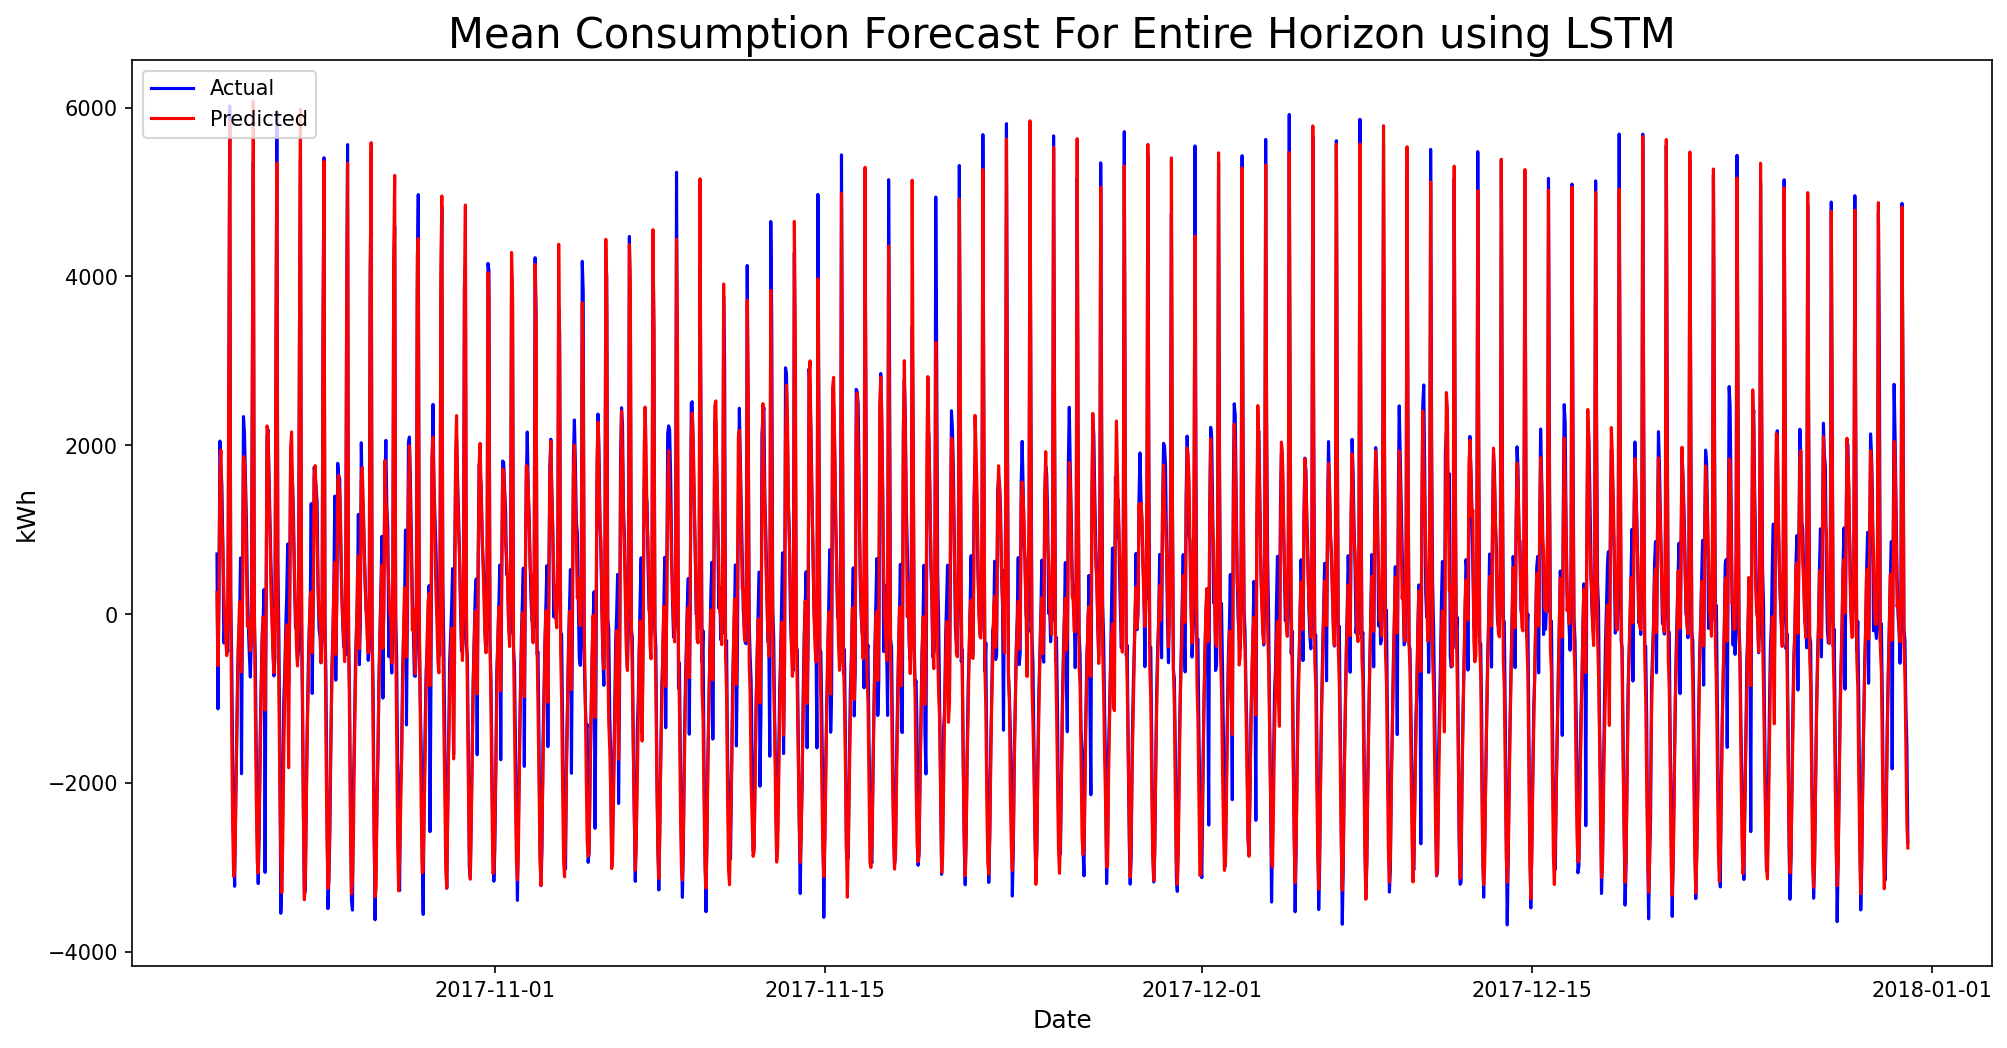

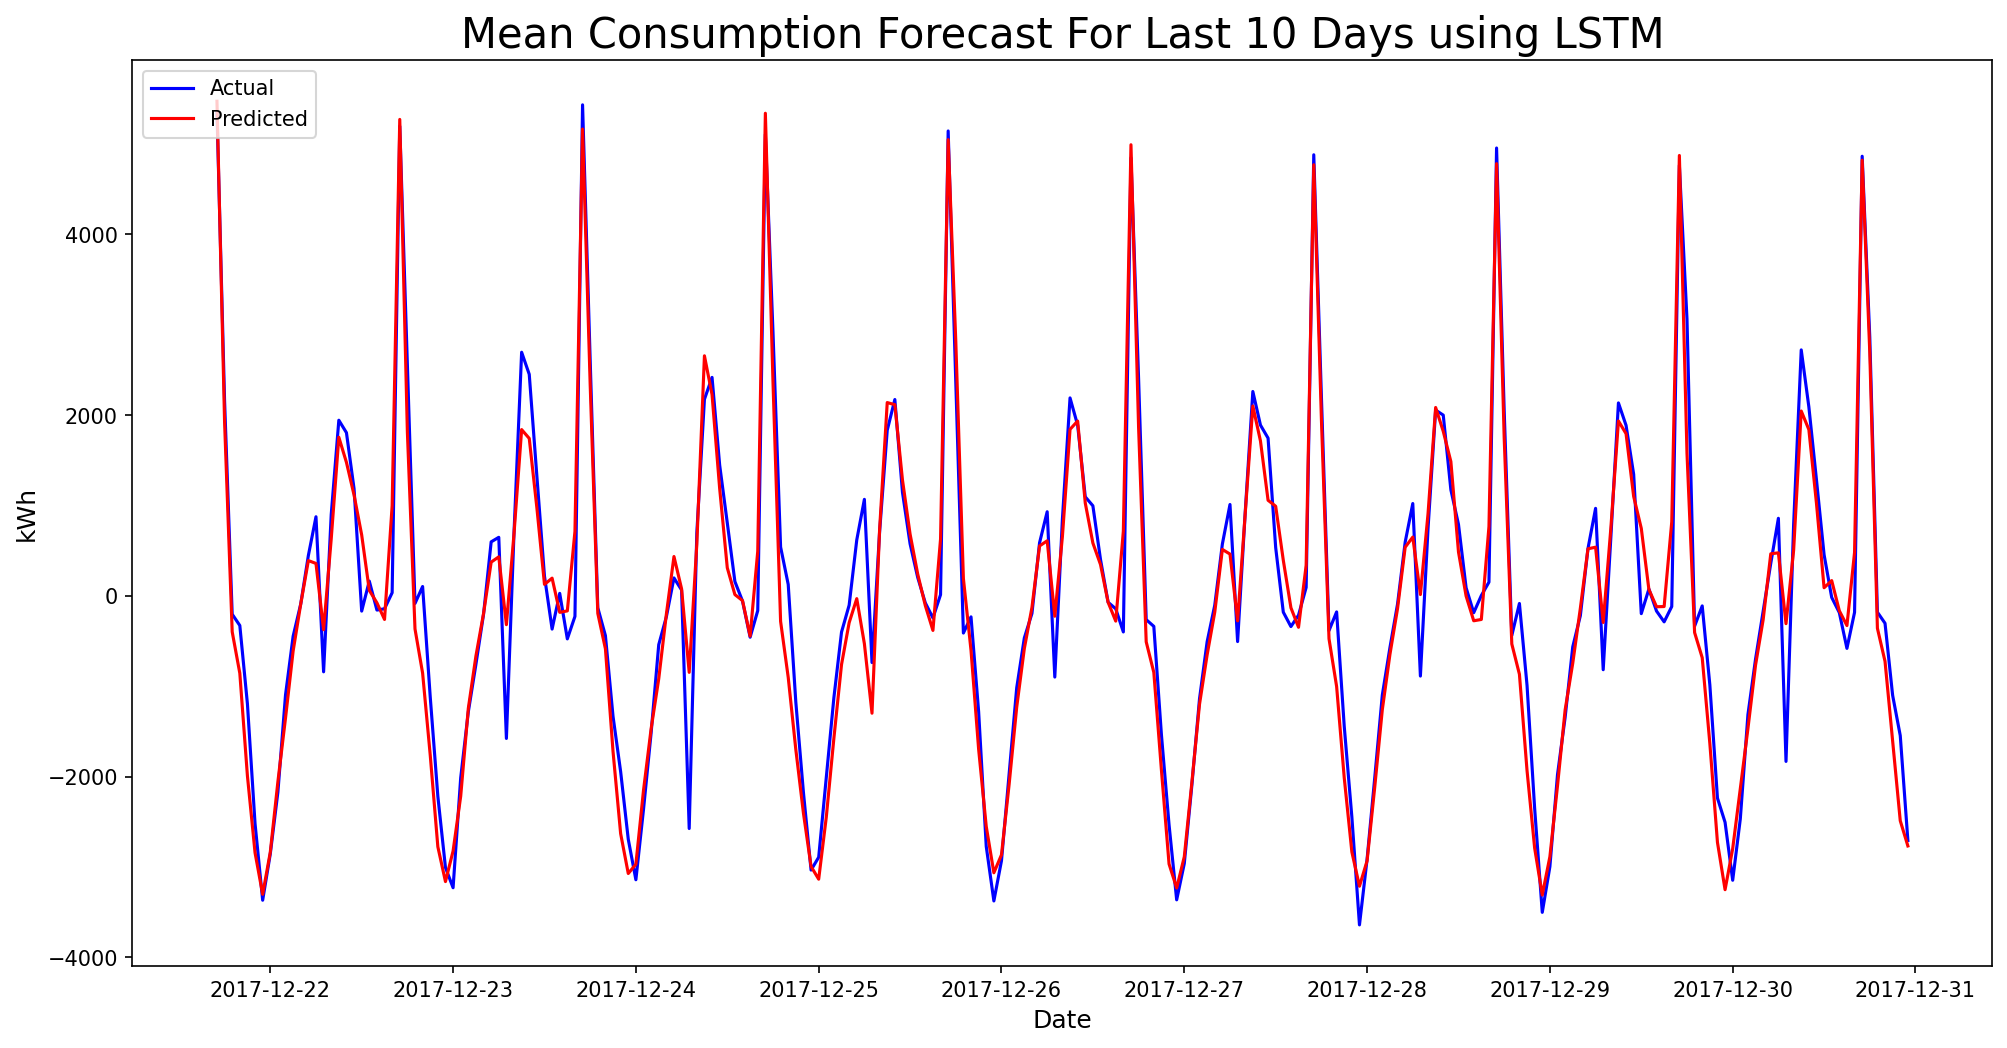

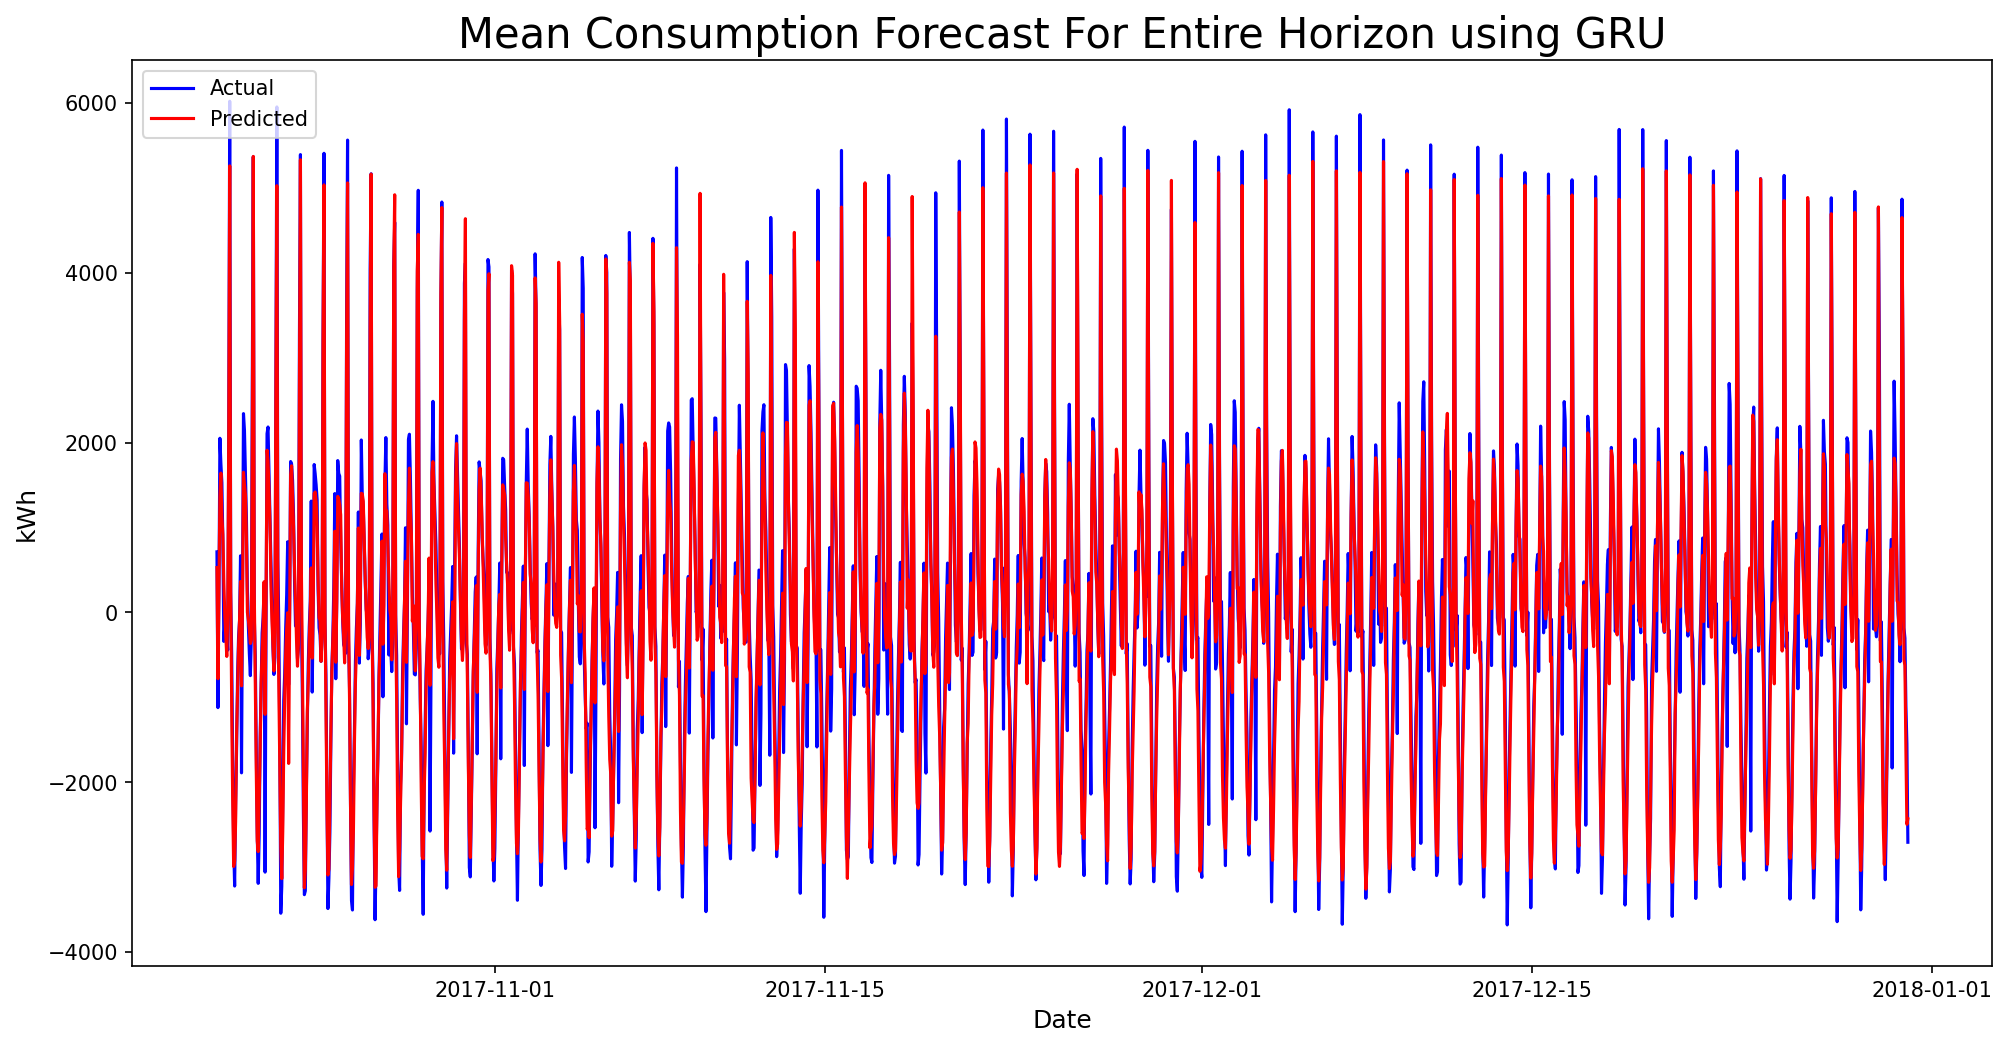

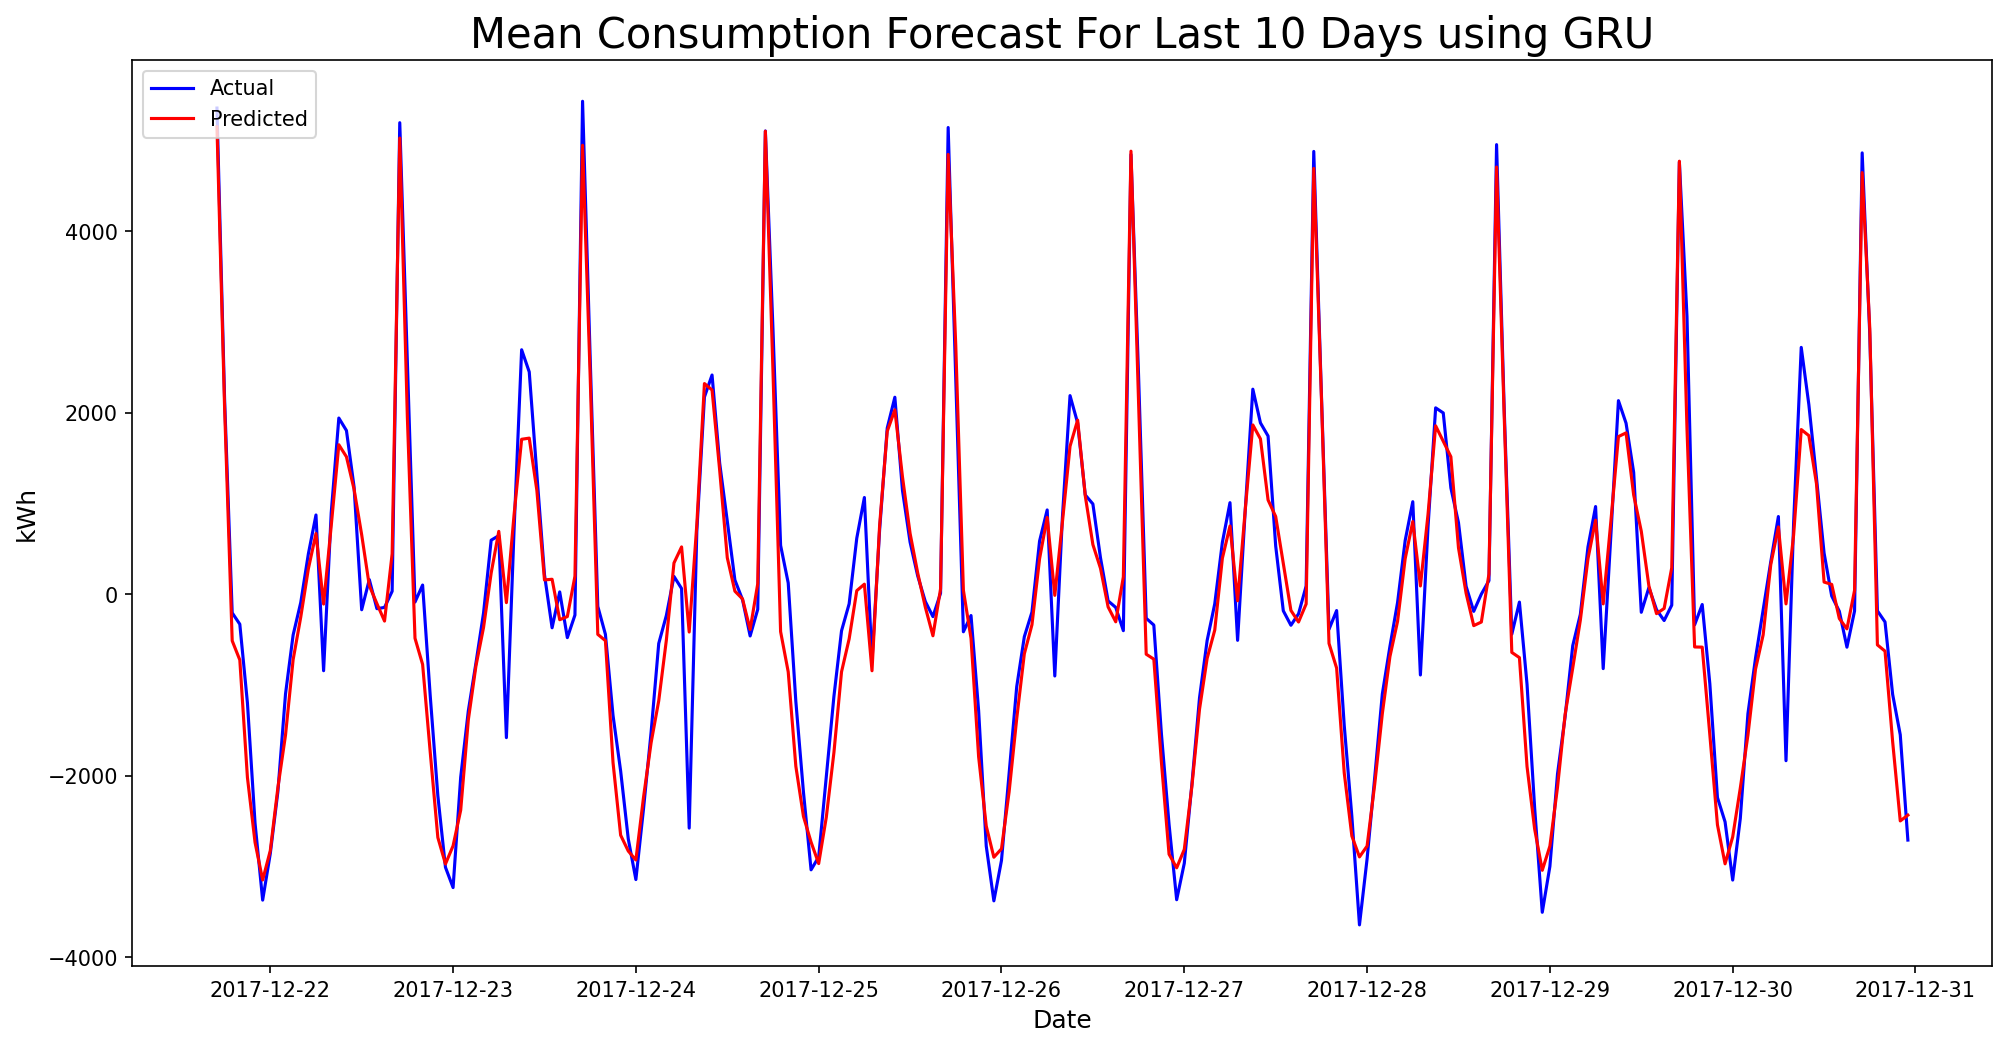

In [ ]:
plot_forecast(predicted_values_LSTM, test_y[n_input:], test_y.index[n_input:], 'Mean Consumption Forecast For Entire Horizon using LSTM', 'MeanConsumptionForecast_LSTM.png')
plot_forecast_lastweek(predicted_values_LSTM, test_y[n_input:], test_y.index[n_input:],'Mean Consumption Forecast For Last 10 Days using LSTM', 'MeanConsumptionForecast_LastWeek_LSTM.png')

plot_forecast(predicted_values_GRU, test_y[n_input:], test_y.index[n_input:], 'Mean Consumption Forecast For Entire Horizon using GRU', 'MeanConsumptionForecast_GRU.png')
plot_forecast_lastweek(predicted_values_GRU, test_y[n_input:], test_y.index[n_input:],'Mean Consumption Forecast For Last 10 Days using GRU', 'MeanConsumptionForecast_LastWeek_GRU.png')


In [ ]:
# save results as df
predictions_LSTM = pd.DataFrame(predicted_values[:,1], columns= ["Predicted values"])
test_Set_LSTM = pd.DataFrame(test_y, columns= ["Test Set values"])
Dates = pd.DataFrame(test_y.index[:-n_input], columns= ["DT"])

#save results as csv
predictions.to_csv('predictions.csv')
test_Set.to_csv('testSet.csv')
Dates.to_csv('Dates.csv')

In [ ]:
# calculate RMSE
from sklearn.metrics import mean_squared_error

# calculate root mean squared error
testScore = np.sqrt(mean_squared_error(test_y[n_input:], predicted_values_LSTM[:,1]))
print('Test Score LSTM: %.2f RMSE' % (testScore))
# calculate root mean squared error
testScore = np.sqrt(mean_squared_error(test_y[n_input:], predicted_values_GRU[:,1]))
print('Test Score GRU: %.2f RMSE' % (testScore))

Test Score LSTM: 444.62 RMSE
Test Score GRU: 432.14 RMSE


# Implementation of Autoregressive Recurrent Neural Network (DeepAR)

DeepAR makes probabilistic forecasts in the form of Monte Carlo samples that can be used to compute consistent quantile estimates for all sub-ranges in the prediction horizon. 

Interestingly, this model creates a single global model for each of the time series considered in the data,  and performs a univariate time series forecasting on each of them.

In this section we will use all the time series concerning energy consumption that are present in our dataset. We will predict the three Tetouan city zones plus the mean consumption that we constructed previously - and used with LSTM and GRU. 

We use the [gluonTS](https://ts.gluon.ai/stable/index.html) library, a Python package built for probabilistic time series modeling, focusing on deep learning based models, based on PyTorch and MXNet.
This library was conceived in 2019 by Alexandrov et al. (https://arxiv.org/abs/1906.05264v2), and it contains multiple built-in functions for time series forecasting, including DeepAR.

The implementation of the model goes as follows:
* We prepare the data selecting our variables of interest (Mean consumption, Electricity Consumption of Zone 1, Zone 2 and Zone 3)
* We split the data into train and test sets, keeping aside the las 20% of the time series
* We build our model parameters and the DeepAR estimator using built-in functions from GluonTS. For example, we use the [ListDataset()](https://ts.gluon.ai/stable/api/gluonts/gluonts.dataset.common.html?highlight=listdataset#gluonts.dataset.common.ListDataset) function that creates the exact formatting of input data that the DeepAR needs to be train multiple forecasts at the same time.
* We train the model
* We predict values on the test set and evaluate thos predictions thanks to the [make_evaluation_predictions](https://ts.gluon.ai/stable/api/gluonts/gluonts.evaluation.backtest.html?highlight=make_evaluation_predictions#gluonts.evaluation.backtest.make_evaluation_predictions) module
* We keep Mean Squared Error and Root Mean Squared Error for comparison with other models
* We plot our results. The the first graph refers to the values for the Mean Consumption, the second graphs represents the model prediction for Zone 1 electricity consumption, the third graph illustrate values for Zone 2 electricity consumption, and the last graph refers to the values for Zone 3. 
In the plots, we represent the predicted values with the red colour, and the observations with the blue colour.

Performance is very good, with the Mean Consumption prediction having the lowest RMSE and Zone 1 having the highest one.

In [ ]:
# support functions 

def data_ar_prep(data):
  data_ar = data.loc[:, ['diff_mean_1', 'diff_mean_Zone1', 'diff_mean_Zone2', 'diff_mean_Zone3']].dropna() # selecting variables of interest and dropping NAs
  data_ar = data_ar.reset_index(drop = True).T.reset_index() # transposing data to have each time step as column 
  return data_ar

def split_train_test(data, test_ratio):
  test_size = int(len(data.columns) * test_ratio)
  df_train = data.iloc[:,1:-test_size].values
  df_test = data.iloc[:,-test_size:].values
  return df_train, df_test

def plot_deepar(ts_entry, forecast_entry):
  plot_length = prediction_length
  prediction_intervals = (80.0, 95.0)
  legend = ['observations', 'median prediction'] + [f'{k}% prediction interval' for k in prediction_intervals][::-1] # last element is for inverting order of values

  fig, ax = plt.subplots(1, 1, figsize = (10, 7))
  ts_entry[-plot_length:].plot(ax = ax)
  forecast_entry.plot(prediction_intervals = prediction_intervals, color ='r')
  plt.ylabel('kWh', fontsize=12)
  plt.xlabel('Date', fontsize=12)
  plt.grid(which= "both")
  plt.legend(legend, loc='upper left')
  plt.show()

def deepar_metrics(item_metrics):

  mse = item_metrics['MSE']
  mse_df = pd.DataFrame(mse, columns = ['MSE'])
  mse_df.index = ['Mean Consumption', 'Zone1', 'Zone2', 'Zone3']
  l = []

  for i in range(len(mse_df)):
    l.append(sqrt(mse_df.iloc[i].loc['MSE']))
  mse_df['RMSE'] = l

  return mse_df

In [ ]:
data_ar = data_ar_prep(stationary_power)
ar_train, ar_test = split_train_test(data_ar, 0.20)

In [ ]:
# build model parameters and DeepAR estimator

freq = '60min' # frequency of data
start_train = pd.Timestamp("2017-01-01 01:00:00", freq= freq) # manually checked specific date where training and test data start
start_test = pd.Timestamp("2017-10-19 05:00:00", freq= freq)
prediction_length = 24 #look back 
var_code = data_ar['index'].astype('category').cat.codes.values # categorical variable built for the model to distinguish the 4 different univariate forecasts to perform

DeepAR = DeepAREstimator(freq = freq, 
                        context_length = 48, # Number of steps to unroll the RNN for before computing predictions: 2 days
                        prediction_length= prediction_length, # Length of the prediction horizon
                        use_feat_static_cat = True, # Whether to use the feat_static_cat field from the data
                        cardinality = [1], # n of cat var to handle
                        num_layers = 4, 
                        num_cells = 48, 
                        cell_type = 'gru', # we can either choose gru or lstm
                        trainer = Trainer(epochs= 50))

# prepare data to be fed into DeepAR model

train = ListDataset([
    {FieldName.TARGET: target,
     FieldName.START: start_train,
     FieldName.FEAT_STATIC_CAT: fsc} 
     for (target, fsc) in zip(ar_train, var_code.reshape(-1, 1))], freq=freq)

test= ListDataset([
    {FieldName.TARGET: target,
     FieldName.START: start_test,
     FieldName.FEAT_STATIC_CAT: fsc} 
     for (target, fsc) in zip(ar_test, var_code.reshape(-1, 1))], freq=freq)

<ipython-input-33-af4f25070f2c>:4: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  start_train = pd.Timestamp("2017-01-01 01:00:00", freq= freq) # manually checked specific date where training and test data start
<ipython-input-33-af4f25070f2c>:5: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  start_test = pd.Timestamp("2017-10-19 05:00:00", freq= freq)


In [ ]:
trained_model = DeepAR.train(training_data=train)

 48%|████▊     | 24/50 [00:10<00:10,  2.39it/s, epoch=49/50, avg_epoch_loss=7.13]

In [ ]:
# make predictions
predicted_values, timeseries = make_evaluation_predictions(
    dataset= test, 
    predictor = trained_model)

forecasts = list(predicted_values)
tss = list(timeseries)

# evaluate predictions 
evaluator = Evaluator(quantiles = [0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)

Running evaluation: 4it [00:00, 82.29it/s]


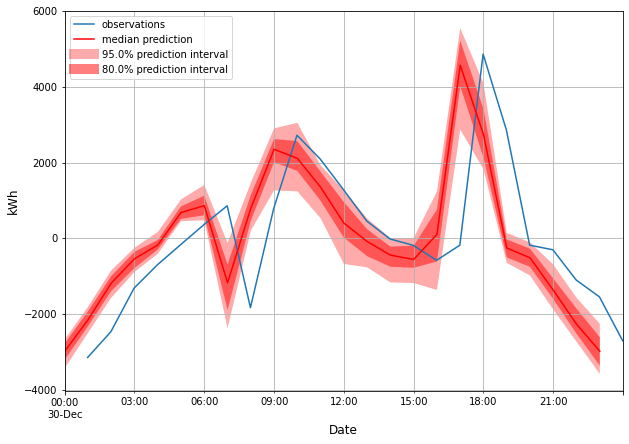

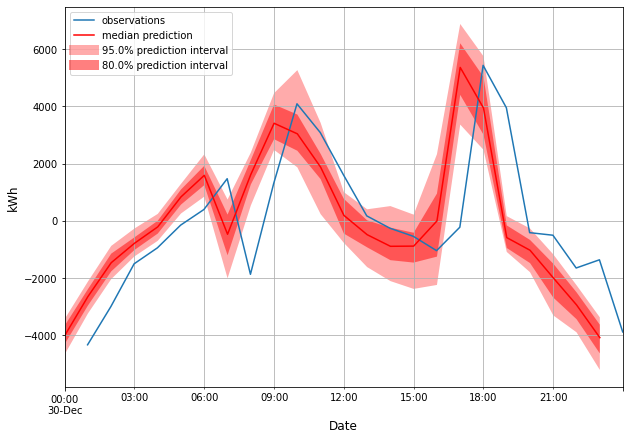

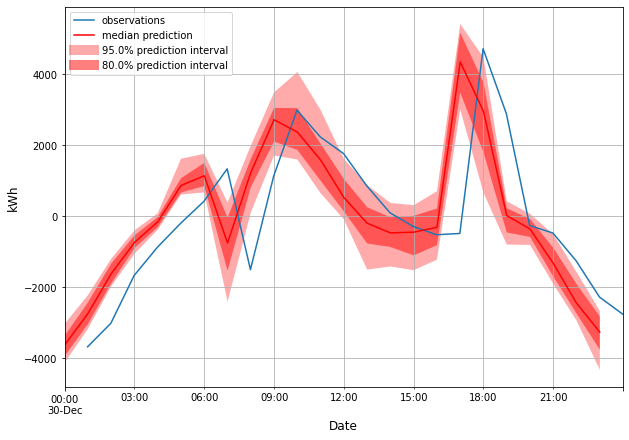

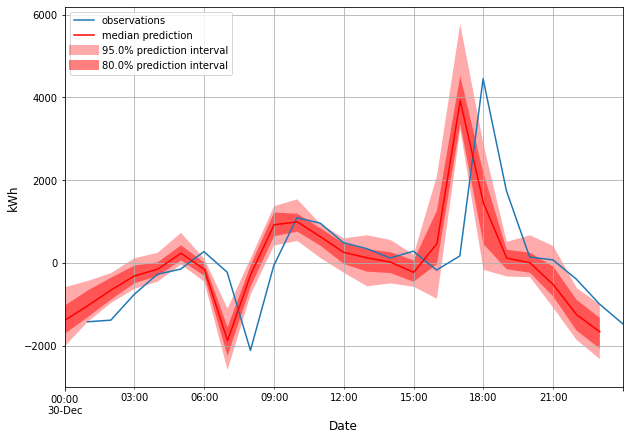

In [ ]:
# plot energy consumption for the last 24h 

for i in range(4):
  ts_entry = tss[i]
  forecast_entry = forecasts[i]
  plot_deepar(ts_entry, forecast_entry)

# Comparing Evaluation Metrics of All Models

In [ ]:
from math import sqrt
from sklearn.metrics import mean_absolute_error

def rmse(e, first=0): return sqrt(np.mean(np.square(e[first:])))
def mae(e, first=0): return np.mean(np.abs(e[first:]))
def mse(e,first=0): return np.mean(np.square(e[first:]))

print("Baseline RMSEs:")
print("(Best Baseline Model) Direct:\t", rmse(y - fc_Mean, n_NaN))
print("Naive:    \t\t\t", rmse(y - fc_Naive, n_NaN))
print("Composite: \t\t\t", rmse(y - fc_Comp, n_NaN), "\n")
print("Deep Learning RMSEs:")
print("LSTM: \t\t\t\t", np.sqrt(mean_squared_error(test_y[n_input:], predicted_values_LSTM[:,1])))
print("GRU: \t\t\t\t", np.sqrt(mean_squared_error(test_y[n_input:], predicted_values_GRU[:,1])), '\n')

print("Baseline MAEs:")
print("(Best Baseline Model) Direct\t", mae(y - fc_Mean, n_NaN))
print("Naive:    \t\t\t", mae(y - fc_Naive, n_NaN))
print("Composite: \t\t\t", mae(y - fc_Comp, n_NaN), "\n\n")
print("Deep Learning MAEs:")
print("LSTM: \t\t\t\t", mean_absolute_error(test_y[n_input:], predicted_values_LSTM[:,1]))
print("GRU: \t\t\t\t", mean_absolute_error(test_y[n_input:], predicted_values_GRU[:,1]), '\n\n')

print("Baseline MSEs:")
print("(Best Baseline Model) Direct\t", mse(y - fc_Mean, n_NaN))
print("Naive:    \t\t\t", mse(y - fc_Naive, n_NaN))
print("Composite: \t\t\t", mse(y - fc_Comp, n_NaN), "\n")
print("Deep Learning MSEs:")
print("LSTM: \t\t\t\t", (mean_squared_error(test_y[n_input:], predicted_values_LSTM[:,1])))
print("GRU: \t\t\t\t", (mean_squared_error(test_y[n_input:], predicted_values_GRU[:,1])), '\n')


Baseline RMSEs:
(Best Baseline Model) Direct:	 966.150731463122
Naive:    			 1152.5012354728833
Composite: 			 975.379931186991 

Deep Learning RMSEs:
LSTM: 				 444.6229618644672
GRU: 				 432.14473813308877 

Baseline MAEs:
(Best Baseline Model) Direct	 669.5599602138535
Naive:    			 760.18744189186
Composite: 			 681.4591806187115 


Deep Learning MAEs:
LSTM: 				 325.9031649377848
GRU: 				 323.9063907954097 


Baseline MSEs:
(Best Baseline Model) Direct	 933447.2359067259
Naive:    			 1328259.0977665223
Composite: 			 951366.0101623393 

Deep Learning MSEs:
LSTM: 				 197689.57821713143
GRU: 				 186749.0746961159 



In [ ]:
metrics = deepar_metrics(item_metrics)
metrics

,MSE,RMSE
Mean Consumption,72619.218750,269.479533
Zone1,256835.875000,506.789774
Zone2,75147.291667,274.130063
Zone3,43775.098958,209.224996
